<a href="https://colab.research.google.com/github/leandro-driguez/Machine-Learning-Techniques/blob/dev/Taller_2/others/Taller_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/hectormelo/Machine-Learning-Techniques/main/Banner.png" ><br>
# Machine Learning Techniques - MISIS4219

Primer semestre - 2024


# **Imports**

In [2]:
import os
import pywt
import mahotas
import requests
import numpy as np
import xgboost as xgb
from PIL import Image
from io import BytesIO
from scipy import stats
import mahotas.features
from zipfile import ZipFile
from joblib import dump, load
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# 1. **Exploración de Datos**

## Descargando y Descomprimiendo el Conjunto de Datos

Antes de que podamos proceder con la carga y el procesamiento de las imágenes, necesitamos obtener el conjunto de datos. Esta sección del cuaderno está dedicada a descargar un archivo ZIP que contiene el conjunto de datos EuroSAT desde una URL de repositorio de GitHub especificada y luego descomprimirlo en un directorio designado. Este paso es crucial para hacer el conjunto de datos accesible para tareas de carga y análisis subsiguientes.

In [3]:
# URL of the ZIP file in the GitHub repository
url = 'https://github.com/hectormelo/Machine-Learning-Techniques/raw/main/Lab_2/EuroSAT3.zip'

# Download the ZIP file
response = requests.get(url)
if response.status_code == 200:
    zip_content = response.content
    # Unzip the content in memory
    with ZipFile(BytesIO(zip_content)) as zip_file:
        # Specify the directory where you want to unzip
        zip_file.extractall("./EuroSAT3")
    print("File successfully unzipped.")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File successfully unzipped.


## Cargando y Etiquetando Imágenes

En esta sección, cargaremos imágenes de diferentes categorías para preparar nuestros datos de entrenamiento. Definimos un conjunto de categorías que corresponden a los nombres de las carpetas donde se almacenan nuestras imágenes. Para cada categoría, cargamos las imágenes, las normalizamos (como se describió en el paso anterior) y asignamos una etiqueta numérica a cada imagen. Esto nos permitirá entrenar un modelo de clasificación de imágenes más adelante en el cuaderno.

El proceso es el siguiente:

1. Definir las categorías de imágenes que queremos cargar.
2. Preparar dos listas: una para almacenar las imágenes y otra para las etiquetas.
3. Iterar sobre cada categoría, cargar las imágenes de esa categoría y asignar una etiqueta numérica a cada imagen basada en su categoría.
4. Convertir las listas de imágenes y etiquetas en arreglos de NumPy para facilitar su manipulación en pasos posteriores de procesamiento o entrenamiento de modelos.

In [4]:
def load_images(folder):
    """
    Load and normalize images from a specified folder.

    This function iterates over all files in the given folder, assuming they are images.
    Each image is converted to an RGB array and normalized to have values between 0 and 1.

    Args:
        folder (str): The path to the folder containing the images.

    Returns:
        list: A list of normalized images represented as numpy arrays.
    """

    # Initialize an empty list to store the normalized images
    images = []

    # Iterate over every file in the specified folder
    for filename in os.listdir(folder):
        # Construct the full path to the file
        image_path = os.path.join(folder, filename)

        try:
            # Open the image, convert it to RGB to ensure consistency, and convert to numpy array
            with Image.open(image_path) as image:
                image = np.array(image.convert("RGB"))
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
            continue

        # Normalize the image data to 0-1 range
        normalized_image = image / 255.0

        # Append the normalized image to our list
        images.append(normalized_image)

    return images

In [5]:
# List of categories corresponding to the folder names of images
categories = ['Forest', 'Industrial', 'PermanentCrop', 'Residential', 'River']
base_path = './EuroSAT3/'  # Base path where the category folders are located

# Initialize lists to store all images and labels
all_images = []
all_labels = []

# Iterate over each category to load the images
for label, category in enumerate(categories):
    # Create the full path to the current category's folder
    folder = os.path.join(base_path, category)
    # Load all images from the current folder
    category_images = load_images(folder)
    # Add the loaded images to the general image list
    all_images.extend(category_images)
    # Assign a corresponding label to each loaded image
    all_labels.extend([label] * len(category_images))

# Convert the lists of images and labels into NumPy arrays
all_images_np = np.array(all_images)
all_labels_np = np.array(all_labels)

## Dividiendo el Conjunto de Datos en Entrenamiento y Pruebas

Después de cargar y preprocesar nuestras imágenes y sus correspondientes etiquetas, el siguiente paso crucial es dividir el conjunto de datos en conjuntos de entrenamiento y pruebas. Esto nos permite entrenar nuestro modelo en una porción de los datos (conjunto de entrenamiento) y luego evaluar su rendimiento en datos no vistos (conjunto de pruebas). Utilizando la función train_test_split de sklearn.model_selection, podemos fácilmente particionar el conjunto de datos de acuerdo a esto. Asignaremos el 80% de los datos para el entrenamiento y reservaremos el 20% para las pruebas. Adicionalmente, establecer un random_state asegura que nuestros resultados sean reproducibles.

In [6]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_images_np, all_labels_np, test_size=0.2, random_state=42)

# Displaying the shapes of the training and testing sets
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (3000, 64, 64, 3)
y_train shape: (3000,)
X_test shape: (750, 64, 64, 3)
y_test shape: (750,)


## Visualizando la Distribución de Clases

Después de dividir nuestro conjunto de datos en conjuntos de entrenamiento y prueba, es importante examinar la distribución de clases dentro de nuestro conjunto de entrenamiento. Este paso nos ayuda a comprender el equilibrio (o desequilibrio) entre las diferentes clases, lo cual puede informarnos sobre posibles sesgos en nuestro conjunto de datos y puede influir en nuestra elección de métricas de evaluación de modelos o en la necesidad de técnicas de remuestreo. A continuación, utilizaremos un histograma para visualizar la distribución de clases en nuestros datos de entrenamiento.

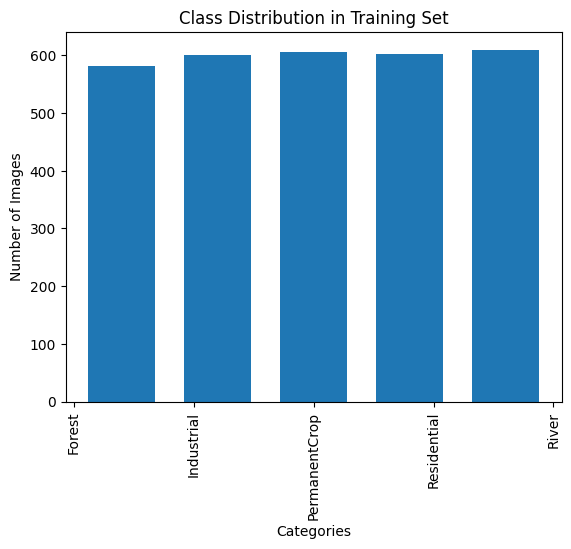

In [7]:
# Visualize the distribution of classes
plt.hist(y_train, bins=len(categories), rwidth=0.7)  # Adjust the number of bins to match the number of categories
plt.xticks(ticks=range(len(categories)), labels=categories, rotation='vertical')  # Label x-axis with category names
plt.title("Class Distribution in Training Set")  # Add a title for clarity
plt.xlabel("Categories")  # Label the x-axis
plt.ylabel("Number of Images")  # Label the y-axis
plt.show()

## Observando Imágenes Aleatorias del Conjunto de Entrenamiento

La inspección visual del conjunto de datos es un paso crucial para entender mejor los datos. Al seleccionar y mostrar aleatoriamente imágenes de nuestro conjunto de entrenamiento, podemos obtener una idea de la variedad y calidad de las imágenes de las que nuestro modelo aprenderá. Este paso también nos permite confirmar visualmente si las etiquetas están correctamente asignadas, identificando potencialmente cualquier anomalía o imágenes mal etiquetadas desde el principio. Vamos a mostrar algunas imágenes aleatorias junto con sus etiquetas para ver ejemplos de cada clase.

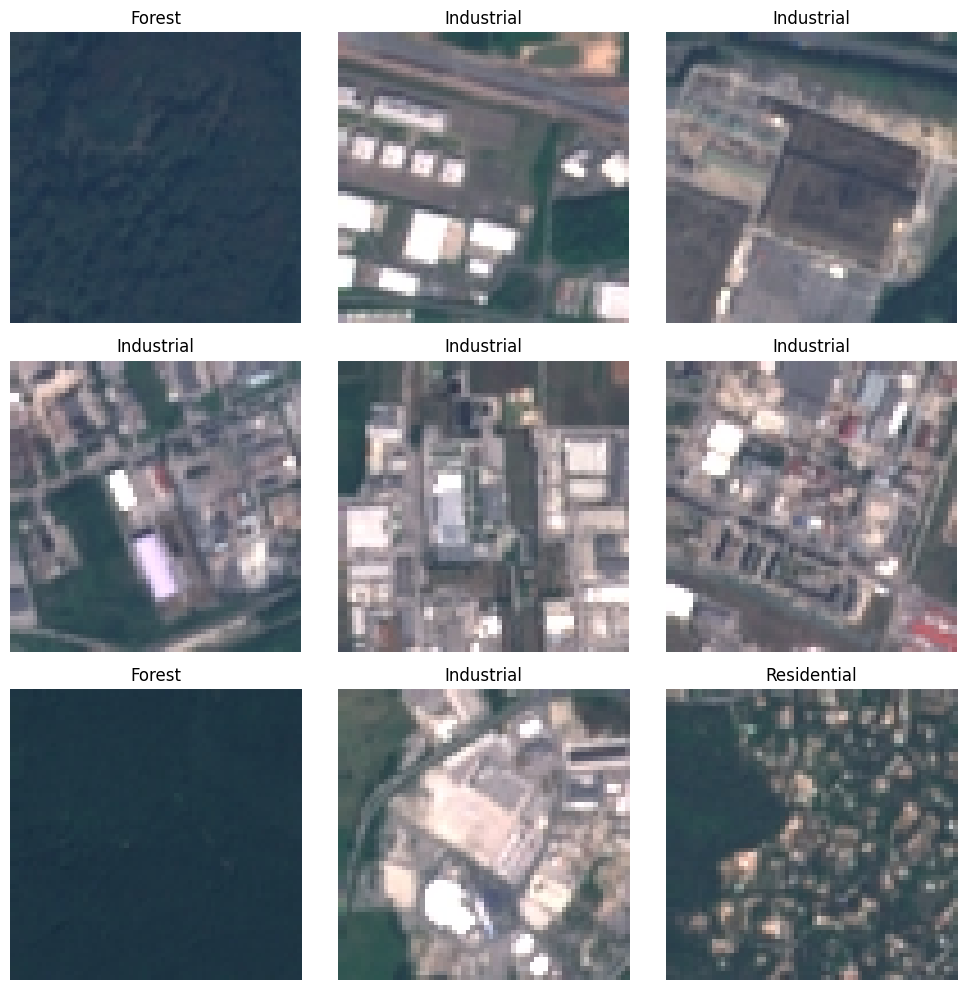

In [8]:
plt.figure(figsize=(10, 10))  # Set the figure size for better visibility

for i in range(9):  # Display 9 images
    plt.subplot(3, 3, i + 1)  # Arrange images in a 3x3 grid
    rnd_idx = np.random.randint(0, len(X_train))  # Select a random index
    plt.imshow(X_train[rnd_idx])  # Display the image at the random index
    plt.title(categories[y_train[rnd_idx]])  # Show the category label as the title
    plt.axis('off')  # Hide the axis for a cleaner look

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

# 2. **Preparación de Datos**

## Ingeniería de Características

Este segmento del notebook se enfoca en la extracción de múltiples tipos de características de las imágenes para preparar nuestros datos para el entrenamiento de modelos de aprendizaje automático. A continuación, se detalla el propósito y la relevancia de cada función:

- `extract_color_stats(image)`: Esta función extrae estadísticas básicas de color, como la media, desviación estándar, varianza, mediana, moda, valor mínimo y máximo, percentiles (25, 50, 75), sesgo, curtosis y rango de cada canal de color de la imagen. Estas estadísticas proporcionan una visión global de la distribución de intensidades de color en la imagen, lo cual puede ser muy relevante para identificar patrones relacionados con ciertas categorías de imágenes en tareas de clasificación o segmentación. Por ejemplo, en la clasificación de imágenes naturales, ciertas estadísticas de color podrían ayudar a distinguir entre imágenes de bosques y océanos.

- `extract_color_histogram(image, bins=32, channel_range=(0, 256))`: Calcula el histograma de color para cada canal de color, lo que proporciona una representación binaria de la distribución de intensidades de color en la imagen. Este tipo de característica es fundamental para entender la distribución general de los colores en la imagen y puede ser crucial para distinguir entre diferentes objetos o escenas que tienden a tener distribuciones de color característicos.

- `extract_haralick_features(image)`: Extrae características de textura de Haralick de la imagen convertida a escala de grises. Las características de Haralick, que incluyen aspectos como homogeneidad, contraste, correlación y otros, describen la textura de la imagen, lo cual es especialmente útil para clasificar imágenes basadas en patrones de textura o para identificar áreas dentro de una imagen que comparten propiedades texturales similares.

- `extract_lbp_features(image, P=8, R=1, method='uniform')`: Calcula el patrón binario local (LBP) de la imagen en escala de grises, un descriptor de textura que es robusto ante cambios en la iluminación. LBP es ampliamente usado para tareas de reconocimiento de texturas y rostros porque captura la estructura local de una imagen de manera eficaz. La relevancia de extraer LBP radica en su capacidad para representar detalles texturales finos que pueden ser determinantes en la clasificación o análisis de imágenes.

- `extract_fft_features(image)`: Aplica la transformada rápida de Fourier (FFT) a la imagen en escala de grises para extraer características basadas en los coeficientes de FFT, como la media y la desviación estándar de las magnitudes de los coeficientes. La FFT permite analizar la imagen en el dominio de la frecuencia, lo cual es útil para identificar patrones periódicos o para distinguir entre texturas basadas en la presencia de frecuencias altas o bajas.

- `extract_wavelet_features(image, mode='haar', level=1)`: Utiliza la transformada wavelet para descomponer la imagen en escala de grises en componentes de baja y alta frecuencia. Las características extraídas de los coeficientes de wavelet son útiles para capturar tanto la textura como la estructura a diferentes escalas, lo que puede ser crucial para aplicaciones como la detección de bordes, la clasificación de texturas y la compresión de imágenes.

- `preprocess_image(image)`: Esta función integra todas las características extraídas por las funciones anteriores en un solo vector de características para cada imagen. La relevancia de esta función radica en su capacidad para combinar múltiples tipos de información (color, textura, frecuencia) en una representación unificada de la imagen, lo que enriquece el conjunto de datos de entrada para los algoritmos de aprendizaje automático y puede mejorar significativamente el rendimiento de los modelos de clasificación o regresión.

La combinación de estas características proporciona una representación detallada y multifacética de las imágenes, aprovechando diferentes aspectos visuales que son esenciales para una amplia variedad de tareas de visión por computadora.

In [9]:
def extract_color_stats(image):
    """
    Extract basic color statistics from an image.

    Args:
        image (ndarray): The image array in RGB format.

    Returns:
        list: A list of statistical features for each color channel including mean,
        standard deviation, variance, median, mode, min, max, 25th percentile,
        50th percentile, 75th percentile, skewness, kurtosis, and range.
    """
    features = []

    for channel in range(image.shape[-1]):
        channel_data = image[:, :, channel].ravel()

        mean = np.mean(channel_data)
        std = np.std(channel_data)
        var = np.var(channel_data)
        median = np.median(channel_data)

        mode_result = stats.mode(channel_data)
        mode = mode_result.mode

        min_val = np.min(channel_data)
        max_val = np.max(channel_data)
        percentile_25 = np.percentile(channel_data, 25)
        percentile_50 = np.percentile(channel_data, 50)
        percentile_75 = np.percentile(channel_data, 75)
        skewness = stats.skew(channel_data)
        kurtosis = stats.kurtosis(channel_data)
        data_range = max_val - min_val

        features.extend([
            mean, std, var, median, mode, min_val, max_val,
            percentile_25, percentile_50, percentile_75,
            skewness, kurtosis, data_range
        ])

    return features

def extract_color_histogram(image, bins=32, channel_range=(0, 256)):
    """
    Extract a color histogram from an image.

    Args:
        image (ndarray): The image array in RGB format.
        bins (int): Number of histogram bins.
        channel_range (tuple): The range of values for each channel.

    Returns:
        ndarray: The concatenated histograms of all color channels.
    """
    histogram = [np.histogram(image[:, :, i], bins=bins, range=channel_range)[0] for i in range(image.shape[-1])]
    return np.concatenate(histogram)

def extract_haralick_features(image):
    """
    Extract Haralick texture features from an image.

    Args:
        image (ndarray): The image array in RGB format.

    Returns:
        ndarray: The mean Haralick features across the four directions.
    """
    gray_image = rgb2gray(image)
    gray_image = (gray_image * 255).astype('uint8')

    features = mahotas.features.haralick(gray_image).mean(axis=0)

    return features

def extract_lbp_features(image, P=8, R=1, method='uniform'):
    """
    Extract Local Binary Pattern (LBP) features from an image.

    Args:
        image (ndarray): The image array in RGB format.
        P (int): Number of circularly symmetric neighbour set points.
        R (float): Radius of circle.
        method (str): Method to extract LBP features.

    Returns:
        ndarray: The histogram of LBP features.
    """
    image_gray = rgb2gray(image)
    lbp = local_binary_pattern(image_gray, P=P, R=R, method=method)

    lbp_hist, _ = np.histogram(lbp, density=True, bins=np.arange(0, P + 3), range=(0, P + 2))
    return lbp_hist

def extract_fft_features(image):
    """
    Extract features from the magnitude spectrum of the image's FFT.

    Args:
        image (ndarray): The image array in RGB format.

    Returns:
        tuple: Mean and standard deviation of the FFT magnitude spectrum.
    """
    fft_coefs = np.fft.fft2(rgb2gray(image))
    fft_abs = np.abs(fft_coefs)

    return np.mean(fft_abs), np.std(fft_abs)

def extract_wavelet_features(image, mode='haar', level=1):
    """
    Extract features using wavelet decomposition from an image.

    Args:
        image (ndarray): The image array in RGB format.
        mode (str): Type of wavelet to use.
        level (int): The level of wavelet decomposition.

    Returns:
        tuple: Mean values of the approximation and detail coefficients.
    """
    coeffs2 = pywt.dwt2(rgb2gray(image), mode)
    cA, (cH, cV, cD) = coeffs2

    return np.mean(cA), np.mean(cH), np.mean(cV), np.mean(cD)

def preprocess_image(image):
    """
    Preprocess an image by extracting comprehensive features.

    Args:
        image (ndarray): The image array in RGB format.

    Returns:
        ndarray: A concatenated feature vector consisting of color statistics,
        color histogram, Haralick, LBP, FFT, and wavelet features.
    """
    color_stats_features = extract_color_stats(image)
    color_histogram_features = extract_color_histogram(image)
    haralick_features = extract_haralick_features(image)
    lbp_features = extract_lbp_features(image)
    fft_features = extract_fft_features(image)
    wlt_features = extract_wavelet_features(image)

    features = np.concatenate([
        color_stats_features, color_histogram_features,
        haralick_features, lbp_features,
        fft_features, wlt_features
    ])
    return features

## Preprocesamiento de los datos

Aplicación de las técnicas antes mencionadas al conjunto `Train` y `Test`.

In [10]:
X_train_preprocessed = np.array([preprocess_image(image) for image in X_train])
X_test_preprocessed = np.array([preprocess_image(image) for image in X_test])

# 3. **Entrenamiento**

In [11]:
xgb_clf = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    tree_method='hist',
    device='cuda',
    max_bin=1024**3,
    verbosity=2
)

param_grid = {
    'n_estimators': [100, 150],
    'learning_rate': [0.1, 0.2],
    'max_depth': [4, 5, 6],
    'colsample_bytree': [0.7, 1.0],
    'subsample': [0.8, 1.0],
}


# Ajusta GridSearchCV para buscar otros parámetros excepto tree_method y max_bin
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Ejecutar la búsqueda
# Asegúrate de tener un conjunto de validación o usar la validación cruzada para determinar la parada temprana
grid_search.fit(X_train_preprocessed, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device='cuda',
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_ra...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 1.0],
                         'learning_rate': [0.1, 0.2], 'max_depth': [4, 5, 6],
                         'n_estimators': [100, 150], 'subsample': [0.8, 1.0]},
             verbose=2)

In [12]:
# Print the best parameters found
print("Best parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

# save best model
dump(best_model, 'best_xgboost.joblib')

Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}


['best_xgboost.joblib']

# 4. **Predicciones**

Accuracy of XGBoost: 0.9746666666666667

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       169
           1       0.98      0.97      0.98       149
           2       0.98      0.95      0.97       145
           3       0.95      0.99      0.97       147
           4       0.96      0.97      0.97       140

    accuracy                           0.97       750
   macro avg       0.97      0.97      0.97       750
weighted avg       0.97      0.97      0.97       750


Confusion Matrix for XGBoost:


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:11:02] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


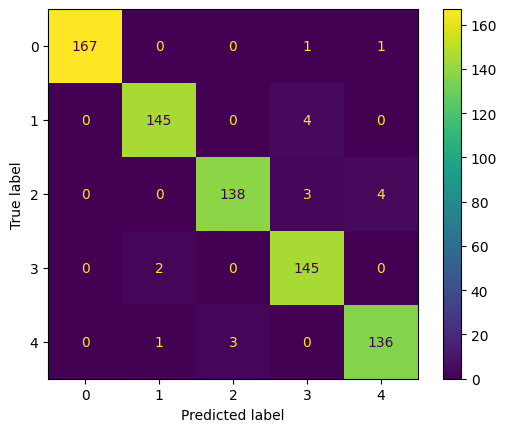

In [13]:
best_model = load('best_xgboost.joblib')

# Predicting on the test set using the best model found by GridSearchCV
y_pred = best_model.predict(X_test_preprocessed)

# Calculating and displaying the model's accuracy
print("Accuracy of XGBoost:", accuracy_score(y_test, y_pred))

# Generating and displaying the classification report, which includes various evaluation metrics
print("\nClassification Report for XGBoost:")
print(classification_report(y_test, y_pred))

# Generating and visualizing the confusion matrix to assess the model's performance in detail
print("\nConfusion Matrix for XGBoost:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()